In [1]:
from mcspace.utils import pickle_load
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib.patches as mpatches
import matplotlib as mpl
import numpy as np

from statsmodels.stats.multitest import multipletests
from scipy.stats import mannwhitneyu
import matplotlib.patches as mpatches

In [2]:
# change font
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"

# Paths

In [3]:
basepath = Path("./")
rootpath = Path("../../")

In [4]:
outpath = basepath / "main_figures"
outpath.mkdir(exist_ok=True, parents=True)

In [5]:
respath = rootpath / "paper" / "results" / "cross_validation"

# Load results

In [6]:
res = pickle_load(respath / "results.pkl")
res = pd.DataFrame(res)

## separate human and mouse cases

In [7]:
all_cases = res['case'].unique()

In [8]:
print(all_cases)

['Human_1_H11' 'Human_2_H11' 'Human_3_H11' 'Human_4_H11' 'Human_5_H11'
 'Mouse_10_JX07' 'Mouse_10_JX08' 'Mouse_10_JX10' 'Mouse_18_JX07'
 'Mouse_18_JX08' 'Mouse_18_JX10' 'Mouse_35_JX07' 'Mouse_35_JX08'
 'Mouse_35_JX10' 'Mouse_43_JX07' 'Mouse_43_JX08' 'Mouse_43_JX10'
 'Mouse_57_JX07' 'Mouse_57_JX08' 'Mouse_57_JX10' 'Mouse_65_JX07'
 'Mouse_65_JX08' 'Mouse_65_JX10' 'Mouse_76_JX07' 'Mouse_76_JX08'
 'Mouse_76_JX10']


In [9]:
mouse_cases = [x for x in all_cases if x.startswith('Mouse')]
human_cases = [x for x in all_cases if x.startswith('Human')]

# Render figure

In [10]:
def annotate_pvalues_single_cond(data, x, value, adjpvals, ax, h, width, text_h, offset):
    # settings
#     h=0.01
#     offset=0.05
#     width = 1.0
    STAR_SIZE = 8*2
    LINEWIDTH = 1.0
    
    n_other = len(adjpvals)
    
    for i in range(n_other):
        x1 = 0 
        x2 = x1 + (i+1)*width + 0.01
        max_y = 1.01*np.amax(data.loc[:,value].values)
        y = max_y + (i+0.5)*offset

        color = 'black'
        pv = adjpvals[i]
        if pv < 0.0001:
            levmarker = "****"
        elif pv < 0.001:
            levmarker = "***"
        elif pv < 0.01:
            levmarker = "**"
        elif pv < 0.05:
            levmarker = "*"
        else:
            levmarker = 'ns'
            color='tab:red'

        ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=LINEWIDTH, c=color)
        ax.text((x1+x2)*0.5, y+text_h, levmarker, ha='center', va='bottom', color=color, fontsize=STAR_SIZE)
    return ax


def compute_corrected_pvalues_single_cond(data, x, y, model_order, base='mcspace'):
    n_other = len(model_order) - 1
    pvalues = np.zeros(n_other)
    for i,mod in enumerate(model_order[1:]):
        base_values = data.loc[(data['model'] == base),y].values
        comp_values = data.loc[(data['model'] == mod),y].values
        pval = mannwhitneyu(base_values, comp_values)
        pvalues[i] = pval.pvalue
    adjpvals = multipletests(pvalues, alpha=0.05, method='fdr_bh')[1]
    return adjpvals


def plot_results_combined(data, ax, palette, model_order, grid=True):
    ax=sns.boxplot(data=data, x='model', y='cosine distance', hue='model', ax=ax, 
                   palette=palette, order=model_order, linewidth=1, showfliers=False)
    if grid:
        ax.set_axisbelow(True)
        ax.yaxis.grid(True, 'major', linewidth=1, color='#e6e6e6')
    return ax


def remove_ylabels(axs):
    for i in range(1,len(axs)):
        plt.setp(axs[i].get_yticklabels(), visible=False)
    return axs


def box_to_ell_axes(ax):
    # Hide the right and top spines
    ax.spines[['right', 'top']].set_visible(False)
    return ax 

In [11]:
palette = [sns.color_palette("Paired")[i] for i in [0,6,4,5]]
human_res = res.loc[res['case'].isin(human_cases),:]
mouse_res = res.loc[res['case'].isin(mouse_cases),:]
holdout_model_order = ['mcspace', 'gmm_basic', 'gmm_one_dim', 'gmm_two_dim']

labels = ['MCSPACE', "GMM", "d-GMM (1D)", "d-GMM (2D)"]
handles = []
for label, color in zip(labels,palette):
    patch = mpatches.Patch(color=color, label=label)
    handles.append(patch)

In [12]:
label_x = -0.1
label_y = 1.0

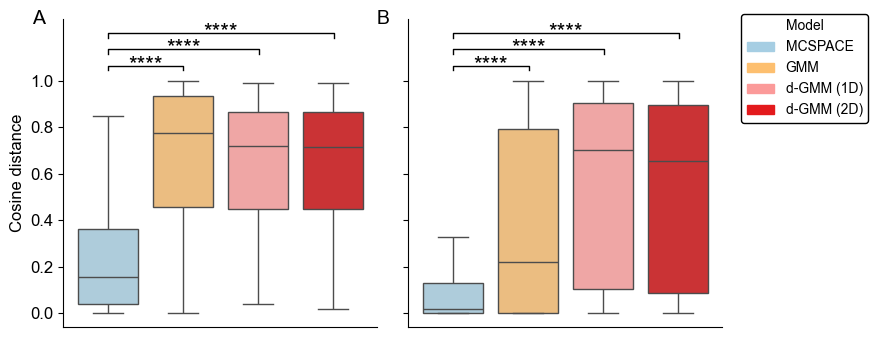

In [14]:
fontsize=12
label_fontsize = 14


fig, ax = plt.subplots(figsize=(8.5,4), ncols=2)

human_adjpvals = compute_corrected_pvalues_single_cond(human_res, x='model', y='cosine distance', model_order=holdout_model_order)
mouse_adjpvals = compute_corrected_pvalues_single_cond(mouse_res, x='model', y='cosine distance', model_order=holdout_model_order)

ax[0] = plot_results_combined(human_res, ax[0], palette, holdout_model_order, grid=False)
ax[0]=annotate_pvalues_single_cond(human_res,'model','cosine distance',human_adjpvals,ax[0],h=0.02, width=1, text_h=-0.02, offset=0.07)
ax[0] = box_to_ell_axes(ax[0])
# ax[0].set_ylim(0,1)
ax[1] = plot_results_combined(mouse_res, ax[1], palette, holdout_model_order, grid=False)
ax[1]=annotate_pvalues_single_cond(mouse_res,'model','cosine distance',human_adjpvals,ax[1],h=0.02, width=1, text_h=-0.02, offset=0.07)
ax[1] = box_to_ell_axes(ax[1])

ax[0].sharey(ax[1])
ax = remove_ylabels(ax)
ax[1].set_ylabel("")
for i in range(2):
    ax[i].set_yticks(np.arange(0,1.1,0.2))
#     ax[i].set_xticklabels(labels, rotation=30, fontsize=fontsize)
    ax[i].set_xticks([])
    ax[i].set_xlabel("")
ax[0].set_yticklabels(ax[0].get_yticklabels(), fontsize=fontsize)
ax[0].set_ylabel("Cosine distance", fontsize=fontsize)
# ax[0].set_title("Human", fontsize=fontsize)
# ax[1].set_title("Mouse", fontsize=fontsize)
plt.subplots_adjust(wspace=0.1)

ax[0].text(label_x, label_y, 'A', horizontalalignment='left',verticalalignment='center', 
             transform=ax[0].transAxes, fontsize=label_fontsize)
ax[1].text(label_x, label_y, 'B', horizontalalignment='left',verticalalignment='center', 
             transform=ax[1].transAxes, fontsize=label_fontsize)

# Legend
lines_labels = [ax[0].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
labels = ['MCSPACE', "Fisher's exact", 'SIM9', 'GMM']
# fig.legend(handles=handles, title='Model', loc='upper right', bbox_to_anchor=(0.85,1.1), ncol=4)
fig.legend(handles=handles, title='Model', loc='upper right', bbox_to_anchor=(1.08,0.91),
                               framealpha=1.0, edgecolor='black')

plt.savefig(outpath / "combined_holdout_results.svg", bbox_inches="tight")